In [5]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib
matplotlib.use("ipympl")
import matplotlib.pyplot as plt

import os
from pathlib import Path
from PIL import Image
from collections import defaultdict

In [16]:
dataset_path = Path("../../data").resolve()
print(dataset_path)

C:\Users\Jinal\Nextcloud\My Stuff\ImpDocs\Masters\Sapienza\Academic\Y1S1\FDS\FDS Project\data


In [13]:
# Classes available
classes = os.listdir(dataset_path)
classes

['cloudy', 'desert', 'green_area', 'water']

In [31]:
# Standard Mean and Standard Deviation used for Resnet18
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [32]:
dataset = ImageFolder(dataset_path, transform=transform)

In [ ]:
# Dividing available dataset into 3 sections - Training (80%), Validation (10%), Test (10%)

train_subset = 0.80

dataset_size = len(dataset)
train_size = int(train_subset * dataset_size)
val_size = int((dataset_size - train_size)\2)
test_size = dataset_size - train_size - val_size

print(dataset_size, train_size, val_size, test_size)

5631 4504 563 564


In [220]:
train_split, val_split, test_split = random_split(dataset=dataset, lengths=[train_size, val_size, test_size])

In [221]:
train_batch_size = 128
val_test_batch_size = 32

In [222]:
train_loader = DataLoader(train_split, batch_size=train_batch_size, shuffle=True)
val_loader = DataLoader(val_split, batch_size=val_test_batch_size, shuffle=False)
test_loader = DataLoader(test_split, batch_size=val_test_batch_size, shuffle=False)

In [223]:
model = models.resnet18(pretrained = True)

c:\Users\Jinal\Nextcloud\My Stuff\ImpDocs\Masters\Sapienza\Academic\Y1S1\FDS\FDS Project\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jinal\Nextcloud\My Stuff\ImpDocs\Masters\Sapienza\Academic\Y1S1\FDS\FDS Project\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [224]:
for paramter in model.parameters():
    paramter.requires_grad = False

for paramter in model.fc.parameters():
    paramter.requires_grad = True

In [225]:
model.fc = nn.Linear(model.fc.in_features, out_features=len(classes))

In [226]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criteria = nn.CrossEntropyLoss()

In [227]:
device = torch.device("cpu")

In [ ]:
def training(model, loader):
    model.train()
    running_loss = 0.0
    running_correct = 0.0
    total = 0.0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
        loss = criteria(outputs, labels)
        
        loss.backward()
        optimizer.step()

        # loss & correct predicitions observed over
        running_loss += loss.item()
        running_correct += torch.sum(predictions == labels)
        total += len(labels)

    return running_loss/len(loader), running_correct/total

In [229]:
def validation(model, loader):
    model.eval()
    running_loss = 0.0
    running_correct = 0.0
    total = 0.0


    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs.data, 1)
            loss = criteria(outputs, labels)

            running_loss += loss.item()
            running_correct += torch.sum(predictions == labels)
            total += len(labels)

    return running_loss/len(loader), running_correct/total
            

In [230]:
epochs = 30

In [231]:
# Early Stopping implementation to avoid overfitting.

def early_stop(metric, patience, delta):
    no_improvement = 0
    if len(metric) > patience:
        for i in range(1, patience+1):
            if metric[-i-1] - metric[-i] <= delta:
                no_improvement += 1
    
    if no_improvement >= patience:
        return True

    return False

In [232]:
model_analysis = defaultdict(list)
patience = 5

for epoch in range(epochs):
    data_per_epoch = {}

    train_loss, train_acc = training(model=model, loader=train_loader)
    val_loss, val_acc = validation(model=model, loader=val_loader)

    print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Avg Val Loss: {val_loss:.4f}, Avg Val Acc: {val_acc:.4f}")

    model_analysis["Train Loss"].append(train_loss)
    model_analysis["Train Acc"].append(train_acc)
    model_analysis["Val Loss"].append(val_loss)
    model_analysis["Val Acc"].append(val_acc)

    # Early stop implemented if loss differnece per epoch does not go above 0.01 over 5 epochs.
    if early_stop(model_analysis["Train Loss"], patience, 0.01):   
        print(f"Early Stop due to no improvement in Average Training Loss over last {patience} epochs")
        break

Epoch: 1, Train Loss: 0.5995, Train Acc: 0.8448, Avg Val Loss: 0.2588, Avg Val Acc: 0.9627
Epoch: 2, Train Loss: 0.1754, Train Acc: 0.9756, Avg Val Loss: 0.1101, Avg Val Acc: 0.9911
Epoch: 3, Train Loss: 0.1025, Train Acc: 0.9878, Avg Val Loss: 0.0762, Avg Val Acc: 0.9947
Epoch: 4, Train Loss: 0.0769, Train Acc: 0.9889, Avg Val Loss: 0.0605, Avg Val Acc: 0.9964
Epoch: 5, Train Loss: 0.0699, Train Acc: 0.9893, Avg Val Loss: 0.0483, Avg Val Acc: 0.9964
Epoch: 6, Train Loss: 0.0550, Train Acc: 0.9922, Avg Val Loss: 0.0434, Avg Val Acc: 0.9947
Epoch: 7, Train Loss: 0.0539, Train Acc: 0.9891, Avg Val Loss: 0.0384, Avg Val Acc: 0.9947
Epoch: 8, Train Loss: 0.0449, Train Acc: 0.9936, Avg Val Loss: 0.0333, Avg Val Acc: 0.9964
Epoch: 9, Train Loss: 0.0382, Train Acc: 0.9931, Avg Val Loss: 0.0305, Avg Val Acc: 0.9964
Epoch: 10, Train Loss: 0.0369, Train Acc: 0.9956, Avg Val Loss: 0.0265, Avg Val Acc: 0.9964
Epoch: 11, Train Loss: 0.0316, Train Acc: 0.9958, Avg Val Loss: 0.0241, Avg Val Acc: 0.99

In [233]:
# Testing 
test_loss, test_correct = validation(model=model, loader=test_loader)
print(f"Loss observed in Testing: {test_loss:.4f}")
print(f"Test Accuracy: {test_correct:.4f}")

Loss observed in Testing: 0.0340
Test Accuracy: 0.9876


In [234]:
model_analysis

defaultdict(list,
            {'Train Loss': [0.5994819696578715,
              0.1753680436975426,
              0.10249415391849147,
              0.07690621146725284,
              0.06985283643007278,
              0.05497828436394533,
              0.05390830819184581,
              0.04493168436197771,
              0.038242463022470474,
              0.03687479217640228,
              0.03161687256457905],
             'Train Acc': [tensor(0.8448),
              tensor(0.9756),
              tensor(0.9878),
              tensor(0.9889),
              tensor(0.9893),
              tensor(0.9922),
              tensor(0.9891),
              tensor(0.9936),
              tensor(0.9931),
              tensor(0.9956),
              tensor(0.9958)],
             'Val Loss': [0.25877194272147286,
              0.1101169122589959,
              0.07621778692636225,
              0.060533478752606444,
              0.04832862069209417,
              0.04343513885719909,
              0.0

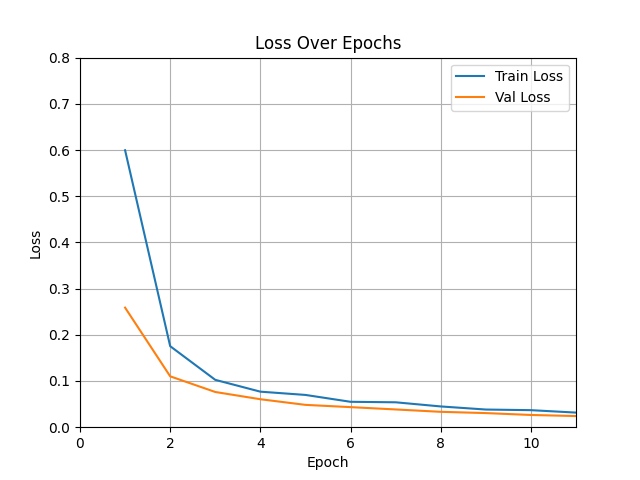

In [245]:
# Learning Curves
x_data_train = model_analysis["Train Loss"]
x_data_val = model_analysis["Val Loss"]
y_data = list(range(1, len(model_analysis["Train Loss"])+1))
plt.plot(y_data, x_data_train, label="Train Loss")
plt.plot(y_data, x_data_val, label="Val Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.grid(True)
plt.xlim(0, len(model_analysis["Train Loss"]))
plt.ylim(0, 0.8)
plt.show()

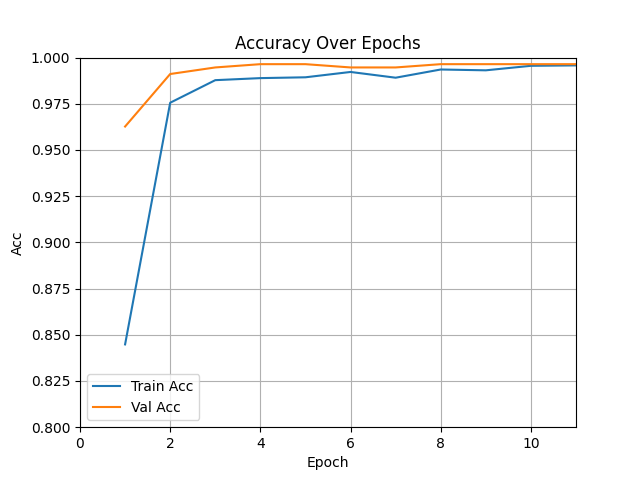

In [243]:
# Learning Curves
x_data_train = model_analysis["Train Acc"]
x_data_val = model_analysis["Val Acc"]
y_data = list(range(1, len(model_analysis["Train Acc"])+1))
plt.plot(y_data, x_data_train, label="Train Acc")
plt.plot(y_data, x_data_val, label="Val Acc")
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.grid(True)
plt.xlim(0, len(model_analysis["Train Acc"]))
plt.ylim(0.8, 1.0)
plt.show()

In [244]:
# Save fine-tuned model's weights and biases
model_data = {
    "model_state_dict" : model.state_dict(),
    "class_to_idx" : dataset.class_to_idx
}
torch.save(model_data, "sat_img_classifier_resnet18.pth")